In [1]:
import warnings # Omitir mensajes de advertencia
warnings.filterwarnings("ignore")

In [2]:
# Trabajamos en colab:
from google.colab import drive
drive.mount('/content/drive/')

import os

path = '/content/drive/MyDrive/Colab Notebooks/Estadistica_Meteo/' # Directorio de trabajo

os.chdir(path)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df = pd.read_csv('Granja Kcayra.txt', sep=' ')
df

,Año,mes,dia,pp_acum,tmax,tmin
0,1964,1,1,0.0,20.5,8.0
1,1964,1,2,0.0,-99.9,4.5
2,1964,1,3,0.0,-99.9,6.0
3,1964,1,4,0.7,-99.9,6.0
4,1964,1,5,1.2,-99.9,9.1
...,...,...,...,...,...,...
18927,2015,10,27,4.2,17.5,8.2
18928,2015,10,28,5.1,18.2,6.2
18929,2015,10,29,0.0,21.7,5.2
18930,2015,10,30,0.5,21.5,8.2


In [5]:
df = df.replace(-99.9, np.nan)
df['time'] = pd.to_datetime(df['Año'].astype(str) + '-' + df['mes'].astype(str) + '-' + df['dia'].astype(str), format='%Y-%m-%d')
df_new = df.copy()
df_new.set_index('time', inplace = True)
df_new = df_new.drop(['Año', 'mes', 'dia'], axis = 1)
df_new.head()

,pp_acum,tmax,tmin
time,,,
1964-01-01,0.0,20.5,8.0
1964-01-02,0.0,NaN,4.5
1964-01-03,0.0,NaN,6.0
1964-01-04,0.7,NaN,6.0
1964-01-05,1.2,NaN,9.1


<Axes: >

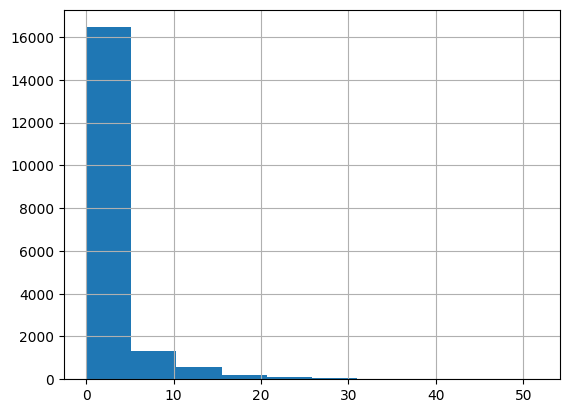

In [6]:
df_new['pp_acum'].hist() # -99.9

In [7]:
# Annual maximum daily rainfall (AMDR)
# Precipitación diaria máxima anual
pp_amdr = df_new['pp_acum'].groupby(pd.Grouper(freq = 'Y')).max()
pp_amdr.head()

time
1964-12-31    23.0
1965-12-31    31.4
1966-12-31    38.0
1967-12-31    42.1
1968-12-31    24.6
Freq: A-DEC, Name: pp_acum, dtype: float64

<Axes: >

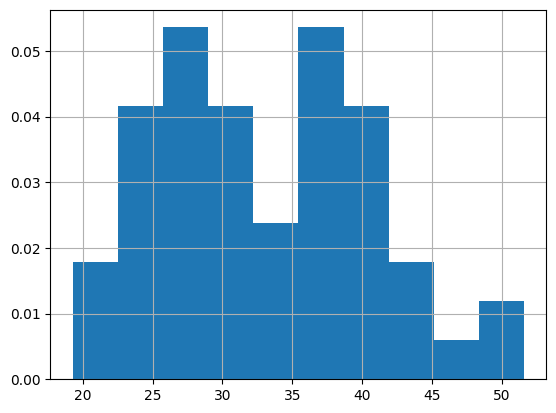

In [8]:
# remove filas con -99.9
indexrows = pp_amdr[pp_amdr == np.nan].index
pp_amdr.drop(indexrows, inplace = True)
pp_amdr.hist(density = True)

In [9]:
# Multiplicamos por un factor de corrección estimado
# Según Miller et al 1973, AMDR, 1.13
pp_amdr = pp_amdr*1.13
pp_amdr.head()

time
1964-12-31    25.990
1965-12-31    35.482
1966-12-31    42.940
1967-12-31    47.573
1968-12-31    27.798
Freq: A-DEC, Name: pp_acum, dtype: float64

In [10]:
# Transformando a un arreglo de numpy
data = pp_amdr.to_numpy()
data

array([25.99 , 35.482, 42.94 , 47.573, 27.798, 28.363, 50.624, 40.793,
       41.358, 32.092, 25.764, 28.25 , 22.6  , 38.307, 30.736, 44.07 ,
       43.166, 45.426, 33.448, 24.182, 41.245, 35.256, 31.075, 47.573,
       39.776, 47.347, 29.945, 42.488, 25.538, 54.805, 44.748, 39.098,
       35.369, 53.11 , 40.567, 21.809, 28.815, 35.03 , 30.171, 44.183,
       34.804, 31.414, 58.308, 37.177, 31.527, 31.414, 46.556, 33.674,
       44.635, 30.736, 40.115, 43.279])

## DISTRIBUCIONES PARAMÉTRICAS





In [11]:
import scipy.stats as stats
import scipy.stats
from scipy.stats import norm, pearson3, chi2, lognorm, gumbel_l, gamma
from scipy.stats import gumbel_r, genextreme, weibull_min
import statsmodels.api as sm

### Forma "Determinística"

In [18]:
dist_names = ['norm', 'lognorm','gamma','genextreme','gumbel_r','weibull_min','chi2','gumbel_l','pearson3']
percentile_bins = np.linspace(0, 100, 11)
percentile_cutoffs = np.percentile(data, percentile_bins)
observed_frequency, bins = np.histogram(data, bins=percentile_cutoffs, density=True)

ksval = []
for distribution in dist_names:
    dist = getattr(scipy.stats, distribution)
    param = dist.fit(data)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    expected_frequency = dist.pdf(bin_centers, *param)
    # Kolmogorov - Smirnov (K-S test) :
    kst = scipy.stats.kstest(data, distribution, param)[0]
    ksval.append(round(kst, 8))
    print(distribution, '(k-s test): ', kst)
# La distribución que mejor se ajusta es la de menor valor
# En este caso "weibull_min"

norm (k-s test):  0.09694817427569236
lognorm (k-s test):  0.08357393183510953
gamma (k-s test):  0.08703268537250486
genextreme (k-s test):  0.08538225631698354
gumbel_r (k-s test):  0.1021358244810816
weibull_min (k-s test):  0.08002611716586294
chi2 (k-s test):  0.25388101246832395
gumbel_l (k-s test):  0.11362821867787037
pearson3 (k-s test):  0.08703044801283366


### Forma "CUALITATIVA" (subjetiva, basada en la visión), histogramas

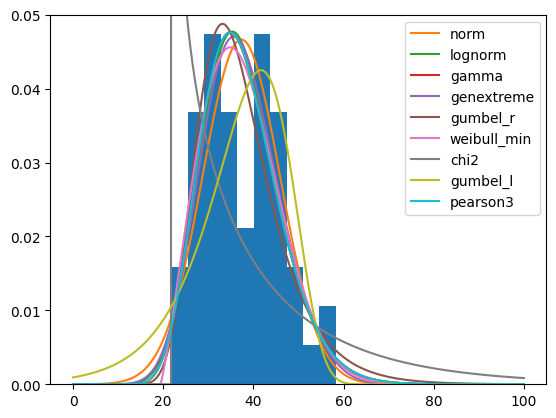

In [13]:
fig1 = plt.figure()
plt.hist(data, density = True)

for i in dist_names:
  fitbest = getattr(scipy.stats, i)
  P = fitbest.fit(data)
  rX = np.linspace(0, 100, 1000)
  rP = fitbest.pdf(rX, *P)
  plt.plot(rX, rP, label = i)
  plt.legend()

plt.ylim(0, 0.05)
plt.show()

### Evaluación "CUALITATIVA" de la bondad de ajuste
### Q-Q plot quantile quantile plot

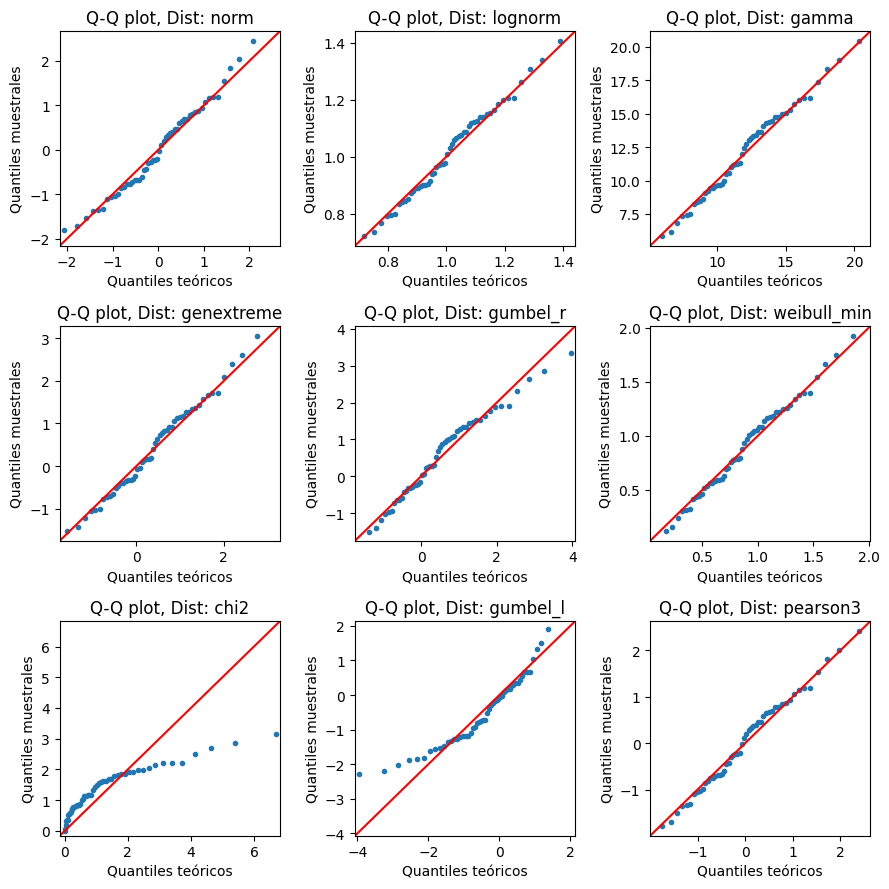

In [14]:
fig, axes = plt.subplots(3, 3, figsize=(9, 9))

for i, ax in zip(dist_names, axes.flatten()):
    dist = getattr(stats, i)
    sm.qqplot(data, dist, fit=True, line='45', ax=ax, markersize=3)
    ax.set_title(f'Q-Q plot, Dist: {i}')
    ax.set_ylabel('Quantiles muestrales')
    ax.set_xlabel('Quantiles teóricos')

plt.tight_layout()
plt.show()